In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [4]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    '../../data_sets/LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,24700.0,24700.0,24700.0,36 months,11.99%,820.28,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,10000.0,10000.0,10000.0,36 months,12.88%,336.37,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,20000.0,20000.0,20000.0,36 months,6.49%,612.89,A,A2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000.0,20000.0,20000.0,36 months,5.32%,602.30,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,18000.0,18000.0,18000.0,36 months,7.49%,559.83,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical column and see what happens off of this kind of naive approach.

In [4]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)

cross_val_score(rfc, X, Y, cv=5)

MemoryError: 

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [6]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
2
term
2
int_rate
111
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
6
pymnt_plan
2
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
54
next_pymnt_d
6
last_credit_pull_d
55
application_type
2
verification_status_joint
1
hardship_flag
2
hardship_type
1
hardship_reason
9
hardship_status
3
hardship_start_date
29
hardship_end_date
30
payment_plan_start_date
30
hardship_loan_status
4
debt_settlement_flag
2
debt_settlement_flag_date
47
settlement_status
3
settlement_date
50


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [7]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [6]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
421092,NaN,NaN,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
421093,NaN,NaN,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
421094,NaN,NaN,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [9]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,settlement_date_Nov-2017,settlement_date_Nov-2018,settlement_date_Oct-2015,settlement_date_Oct-2016,settlement_date_Oct-2017,settlement_date_Oct-2018,settlement_date_Sep-2015,settlement_date_Sep-2016,settlement_date_Sep-2017,settlement_date_Sep-2018
0,NaN,NaN,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,10000.0,10000.0,10000.0,12.88,336.37,91392.0,9.44,0.0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,20000.0,20000.0,20000.0,6.49,612.89,55000.0,29.15,0.0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,20000.0,20000.0,20000.0,5.32,602.30,65000.0,18.83,0.0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,18000.0,18000.0,18000.0,7.49,559.83,75000.0,25.65,0.0,...,0,0,0,0,0,0,0,0,0,0
5,NaN,NaN,17475.0,17475.0,17475.0,13.99,597.17,39750.0,23.58,0.0,...,0,0,0,0,0,0,0,0,0,0
6,NaN,NaN,16000.0,16000.0,16000.0,12.88,363.07,90000.0,6.39,0.0,...,0,0,0,0,0,0,0,0,0,0
7,NaN,NaN,23850.0,23850.0,23850.0,17.27,596.21,68046.0,24.71,1.0,...,0,0,0,0,0,0,0,0,0,0
8,NaN,NaN,35000.0,35000.0,35000.0,12.88,794.21,106000.0,17.36,0.0,...,0,0,0,0,0,0,0,0,0,0
9,NaN,NaN,16250.0,16250.0,16250.0,13.44,373.41,50000.0,34.95,0.0,...,0,0,0,0,0,0,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [10]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.

array([0.99031155, 0.99035881, 0.99097602, 0.99171218, 0.9928758 ,
       0.99190216, 0.99318419, 0.99202052, 0.99280422, 0.99297046])

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [ ]:
# Your code here.

In [22]:
y2015[["loan_status"]].head(20)

,loan_status
0,Fully Paid
1,Fully Paid
2,Fully Paid
3,Fully Paid
4,Fully Paid
5,Charged Off
6,Current
7,Current
8,Charged Off
9,Current


In [18]:
y2015.dtypes

id                       float64
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 136, dtype: object


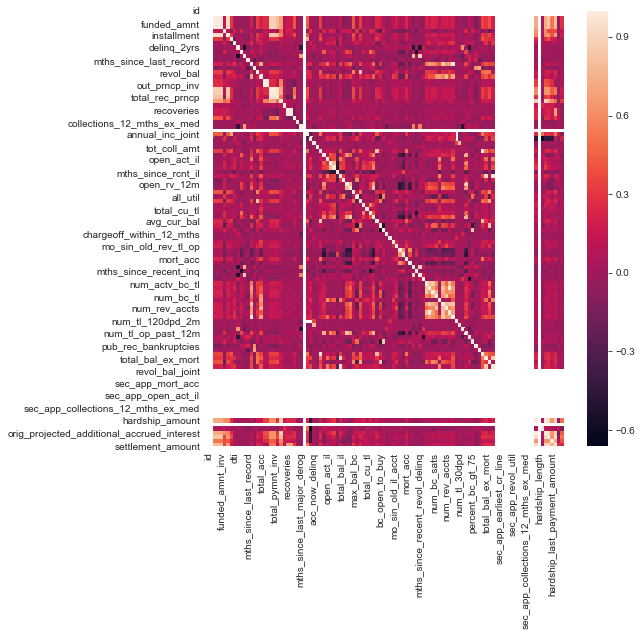

In [16]:
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
sns.heatmap(y2015.corr())

In [20]:
y2015_corr = y2015.corr()
for column in y2015.columns:
    print("column: {}, dtype: {}".format(column, type(column), ))

column: id, dtype: <class 'str'>
column: member_id, dtype: <class 'str'>
column: loan_amnt, dtype: <class 'str'>
column: funded_amnt, dtype: <class 'str'>
column: funded_amnt_inv, dtype: <class 'str'>
column: term, dtype: <class 'str'>
column: int_rate, dtype: <class 'str'>
column: installment, dtype: <class 'str'>
column: grade, dtype: <class 'str'>
column: emp_length, dtype: <class 'str'>
column: home_ownership, dtype: <class 'str'>
column: annual_inc, dtype: <class 'str'>
column: verification_status, dtype: <class 'str'>
column: issue_d, dtype: <class 'str'>
column: loan_status, dtype: <class 'str'>
column: pymnt_plan, dtype: <class 'str'>
column: purpose, dtype: <class 'str'>
column: title, dtype: <class 'str'>
column: dti, dtype: <class 'str'>
column: delinq_2yrs, dtype: <class 'str'>
column: inq_last_6mths, dtype: <class 'str'>
column: mths_since_last_delinq, dtype: <class 'str'>
column: mths_since_last_record, dtype: <class 'str'>
column: open_acc, dtype: <class 'str'>
column: p

In [25]:
rfc.fit(X, Y).feature_importances_

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([1.51148966e-02, 1.50516337e-02, 7.18572784e-03, 2.35192527e-03,
       1.40216722e-02, 1.46382131e-03, 3.64296322e-04, 5.39254022e-04,
       9.66269954e-04, 3.39464395e-04, 1.62730247e-03, 1.18236462e-03,
       1.14855207e-01, 5.07435946e-02, 2.66297514e-02, 4.56254667e-02,
       7.29760982e-02, 1.83207105e-02, 5.42659379e-03, 1.57530824e-01,
       5.97958680e-02, 8.90681770e-02, 8.89387959e-05, 0.00000000e+00,
       3.31483051e-05, 4.27458624e-04, 1.69468905e-03, 1.50798563e-03,
       2.90376945e-03, 1.65102382e-03, 3.80366696e-05, 3.75877782e-05,
       1.51268924e-03, 1.18569102e-03, 1.05801689e-03, 6.99519797e-04,
       4.53289415e-04, 8.71581626e-04, 1.06272528e-03, 9.88282394e-04,
       1.07016289e-03, 1.19630055e-03, 1.11262823e-03, 1.02060184e-03,
       1.06535054e-03, 1.36825769e-05, 1.70303371e-04, 9.35204798e-04,
       8.85727471e-04, 2.31776842e-04, 1.88524229e-04, 1.73961562e-03,
       1.44647732e-03, 1.36224908e-03, 1.22619058e-03, 1.44096529e-02,
      

In [60]:
feature_list = list(zip(X.columns, rfc.feature_importances_))
feature_list.sort(key=(lambda x: x[1]), reverse=True)
print("Features sorted by importance:")
for feature in feature_list:
    print("{}: {}".format(feature[0], feature[1]))

Features sorted by importance:
recoveries: 0.15753082375330346
out_prncp: 0.11485520660047337
last_pymnt_amnt: 0.08906817701111344
total_rec_prncp: 0.072976098201908
collection_recovery_fee: 0.05979586795277917
last_pymnt_d_Jun-2019: 0.05396908765171728
out_prncp_inv: 0.0507435945917306
next_pymnt_d_Jul-2019: 0.04626641263190641
total_pymnt_inv: 0.04562546671673167
term_ 60 months: 0.032450745099002
total_pymnt: 0.026629751360782918
total_rec_int: 0.018320710486844107
loan_amnt: 0.015114896619067194
funded_amnt: 0.015051633664816188
debt_settlement_flag_Y: 0.014721431728461618
term_ 36 months: 0.014409652888872576
installment: 0.014021672201107619
last_credit_pull_d_Feb-2017: 0.012485769674524978
debt_settlement_flag_N: 0.011386690578912593
last_credit_pull_d_Oct-2016: 0.008465709517307973
funded_amnt_inv: 0.007185727835409517
settlement_status_COMPLETE: 0.006289301544785834
total_rec_late_fee: 0.005426593793885268
last_credit_pull_d_Jun-2019: 0.00425597206459542
grade_A: 0.00421795846

In [64]:
feature_list_small = [feature[0] for feature in feature_list if feature[1] > .01]
feature_list_small

['recoveries',
 'out_prncp',
 'last_pymnt_amnt',
 'total_rec_prncp',
 'collection_recovery_fee',
 'last_pymnt_d_Jun-2019',
 'out_prncp_inv',
 'next_pymnt_d_Jul-2019',
 'total_pymnt_inv',
 'term_ 60 months',
 'total_pymnt',
 'total_rec_int',
 'loan_amnt',
 'funded_amnt',
 'debt_settlement_flag_Y',
 'term_ 36 months',
 'installment',
 'last_credit_pull_d_Feb-2017',
 'debt_settlement_flag_N']

In [70]:
y2015_small = y2015[y2015.columns[y2015.columns.isin(feature_list_small)]]
X_small = pd.get_dummies(y2015_small, drop_first=True)

In [71]:
rfc2 = ensemble.RandomForestClassifier()
cross_val_score(rfc2, X_small, Y, cv=10)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.

array([0.98425627, 0.99413455, 0.99346948, 0.99308953, 0.99299454,
       0.9929233 , 0.99261423, 0.99294671, 0.99370666, 0.99396789])

In [76]:
y2015_smaller = y2015[y2015.columns[y2015.columns.isin(feature_list_small[:5])]]
X_smaller = pd.get_dummies(y2015_smaller, drop_first=True)
rfc3 = ensemble.RandomForestClassifier()
cross_val_score(rfc3, X_smaller, Y, cv=10)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.

array([0.97214571, 0.98029019, 0.97763002, 0.97974353, 0.9804322 ,
       0.97876989, 0.97791394, 0.97872138, 0.980835  , 0.97976632])

In [77]:
y2015_smaller2 = y2015[y2015.columns[y2015.columns.isin(feature_list_small[:2])]]
X_smaller2 = pd.get_dummies(y2015_smaller2, drop_first=True)
rfc4 = ensemble.RandomForestClassifier()
cross_val_score(rfc4, X_smaller2, Y, cv=10)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.

array([0.93766622, 0.9372373 , 0.93951555, 0.93873189, 0.94018048,
       0.9431014 , 0.94392989, 0.9415313 , 0.94269497, 0.94554479])

In [78]:
y2015_smaller5 = y2015[y2015.columns[y2015.columns.isin(feature_list_small[:1])]]
X_smaller5 = pd.get_dummies(y2015_smaller5, drop_first=True)
rfc5 = ensemble.RandomForestClassifier()
cross_val_score(rfc5, X_smaller5, Y, cv=10)

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.

array([0.85179996, 0.85041913, 0.85205414, 0.85091427, 0.85302778,
       0.85485633, 0.85627434, 0.85416073, 0.85430322, 0.85670181])

In [81]:
#optimal reduced feature set:
y2015_smaller2.head(10)

,out_prncp,recoveries
0,0.00,0.00
1,0.00,0.00
2,0.00,0.00
3,0.00,0.00
4,0.00,0.00
5,0.00,4382.00
6,6210.21,0.00
7,9849.18,0.00
8,0.00,7079.69
9,6358.68,0.00
